In [ ]:
import pandas as pd
import numpy as np
import nltk
import spacy
import torch
import os
from sentence_transformers import SentenceTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
from transformers import (
    BertForSequenceClassification, BertTokenizer,
    Trainer, TrainingArguments
)
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

nltk.download("stopwords")
nlp = spacy.load("en_core_web_sm")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def load_and_clean_data():
    if os.path.exists("cleaned_data.csv"):
        df = pd.read_csv("cleaned_data.csv")
        print("Загружены очищенные данные")
    else:
        fake_df = pd.read_csv("Fake.csv", usecols=["subject", "text"])
        true_df = pd.read_csv("True.csv", usecols=["subject", "text"])
        fake_df = fake_df[fake_df["subject"] == "politics"].drop(columns=["subject"])
        true_df = true_df[true_df["subject"] == "politicsNews"].drop(columns=["subject"])
        fake_df["label"] = 0
        true_df["label"] = 1
        df = pd.concat([fake_df, true_df], ignore_index=True)

        from nltk.corpus import stopwords
        stop_words = set(stopwords.words("english"))

        def preprocess(text):
            doc = nlp(text.lower())
            return " ".join([token.lemma_ for token in doc if token.is_alpha and token.text not in stop_words])

        df["text"] = df["text"].astype(str).apply(preprocess)
        df.dropna(subset=["text"], inplace=True)

        df.to_csv("cleaned_data.csv", index=False)
        print("Сохранены очищенные данные")
    return df


In [ ]:
def embed_texts(df):
    model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings_file = "embeddings.npy"
    labels_file = "labels.npy"
    df["text"] = df["text"].astype(str).fillna("")

    if os.path.exists(embeddings_file) and os.path.exists(labels_file):
        X = np.load(embeddings_file)
        y = np.load(labels_file)
        print("Загружены ранее вычисленные эмбеддинги")
    else:
        X = model.encode(df["text"].tolist(), batch_size=64, convert_to_numpy=True, show_progress_bar=True)
        y = df["label"].values
        np.save(embeddings_file, X)
        np.save(labels_file, y)
        print("Эмбеддинги сохранены")
    return X, y


In [ ]:
def train_nb(X_train, y_train, X_test):
    model = GaussianNB()
    model.fit(X_train, y_train)
    return model.predict(X_test)


In [ ]:
def train_rf(X_train, y_train, X_test):
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    return model.predict(X_test)


In [ ]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [ ]:
def train_bert(df):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_path = "./bert_model"
    predictions_path = "bert_predictions.npy"
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)

    texts_train, texts_test, y_train, y_test = train_test_split(df["text"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42)
    train_dataset = NewsDataset(texts_train, y_train, tokenizer)
    test_dataset = NewsDataset(texts_test, y_test, tokenizer)

    if os.path.exists(predictions_path):
        print("Загружены предсказания BERT из файла")
        preds = np.load(predictions_path)
    else:
        args = TrainingArguments(
            output_dir=model_path,
            num_train_epochs=3,
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            logging_dir="./logs",
            logging_steps=10,
            save_strategy="no"
        )
        trainer = Trainer(model=model, args=args, train_dataset=train_dataset, eval_dataset=test_dataset)
        trainer.train()
        print("Предсказания модели BERT...")
        predictions = trainer.predict(test_dataset)
        preds = predictions.predictions.argmax(axis=1)
        np.save(predictions_path, preds)
        trainer.save_model(model_path)
        print("BERT модель и предсказания сохранены")

    return y_test, preds


In [ ]:
def evaluate_models(y_test, y_pred_nb, y_pred_rf, y_pred_bert):
    models = {
        "Naïve Bayes": y_pred_nb,
        "Random Forest": y_pred_rf,
        "BERT Classifier": y_pred_bert
    }
    results = {}
    for name, y_pred in models.items():
        results[name] = {
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1 Score": f1_score(y_test, y_pred),
            "ROC AUC": roc_auc_score(y_test, y_pred)
        }

    for name, metrics in results.items():
        print(f"{name}:")
        for metric_name, value in metrics.items():
            print(f"{metric_name}: {value:.4f}")
        print()

    metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score"]
    x = np.arange(len(metrics_names))
    width = 0.25

    plt.figure(figsize=(10, 6))
    for i, (name, metrics) in enumerate(results.items()):
        scores = [metrics[m] for m in metrics_names]
        plt.bar(x + i * width, scores, width=width, label=name)

    plt.xticks(x + width, metrics_names)
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.title("Сравнение моделей по метрикам")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

    for name, y_pred in models.items():
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(4, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Confusion Matrix: {name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()

    best = max(models.items(), key=lambda x: f1_score(y_test, x[1]))
    print(f"Лучшая модель: {best[0]}")


In [ ]:
def classify_single_article_with_bert():
    if not os.path.exists("article.txt"):
        print("Файл article.txt не найден")
        return

    with open("article.txt", "r", encoding="utf-8") as f:
        article_text = f.read()

    from nltk.corpus import stopwords
    stop_words = set(stopwords.words("english"))
    article_clean = " ".join([
        token.lemma_ for token in nlp(article_text.lower())
        if token.is_alpha and token.text not in stop_words
    ])

    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    inputs = tokenizer(article_clean, truncation=True, padding=True, return_tensors="pt", max_length=512)

    model = BertForSequenceClassification.from_pretrained("./bert_model")
    model.eval()

    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=1).item()

    label = "REAL" if prediction == 1 else "FAKE"
    print(f"\nРезультат классификации статьи из article.txt: {label}")


Загружены очищенные данные


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Загружены ранее вычисленные эмбеддинги


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Загружены предсказания BERT из файла
Naïve Bayes:
Accuracy: 0.8808
Precision: 0.8995
Recall: 0.9114
F1 Score: 0.9054
ROC AUC: 0.8704

Random Forest:
Accuracy: 0.9092
Precision: 0.9018
Recall: 0.9595
F1 Score: 0.9297
ROC AUC: 0.8922

BERT Classifier:
Accuracy: 0.9970
Precision: 0.9982
Recall: 0.9969
F1 Score: 0.9976
ROC AUC: 0.9970



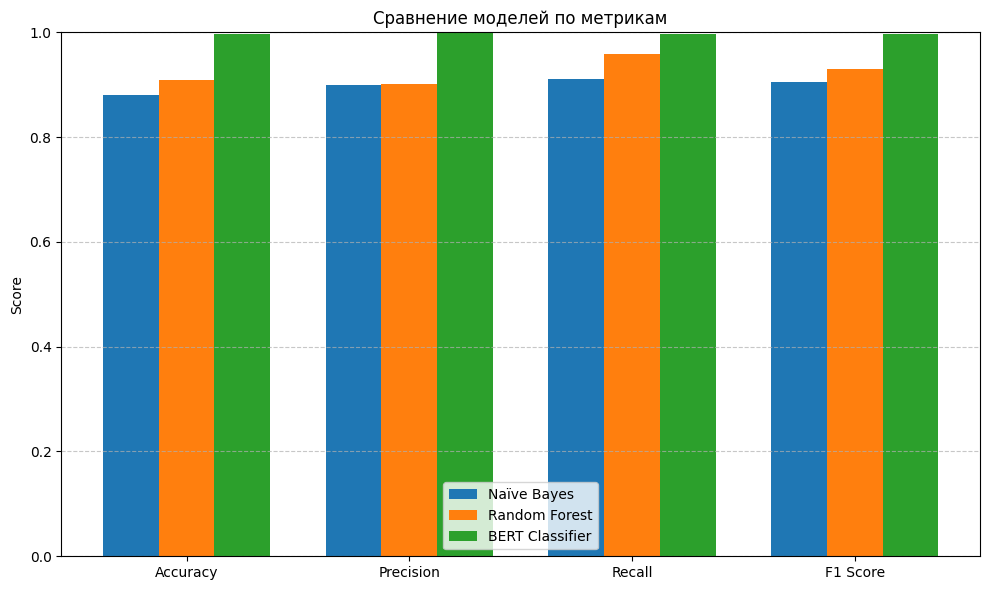

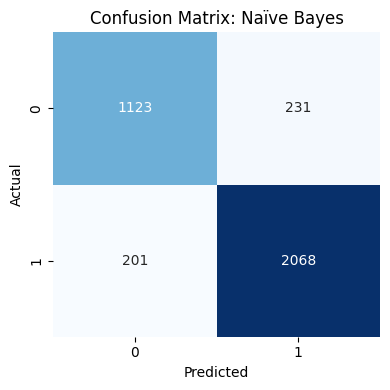

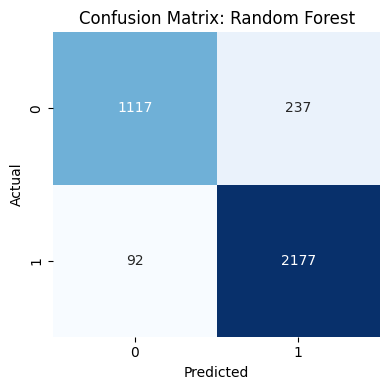

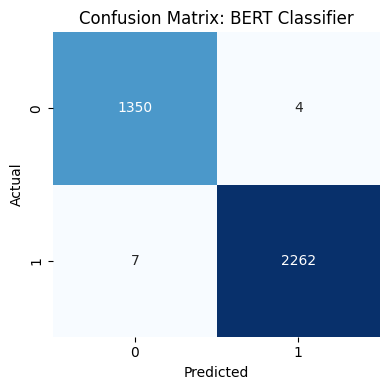

Лучшая модель: BERT Classifier
Файл article.txt не найден


In [ ]:
def run_pipeline():
    df = load_and_clean_data()
    X, y = embed_texts(df)
    X_train, X_test, y_train, y_test_split = train_test_split(X, y, test_size=0.2, random_state=42)
    y_pred_nb = train_nb(X_train, y_train, X_test)
    y_pred_rf = train_rf(X_train, y_train, X_test)
    y_test_bert, y_pred_bert = train_bert(df)
    evaluate_models(y_test_bert, y_pred_nb, y_pred_rf, y_pred_bert)
    classify_single_article_with_bert()

run_pipeline()